In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import scienceplots
plt.style.use('science')
%matplotlib inline

In [2]:
compiled_data = pd.read_csv('compiled_data.csv')
compiled_data['ww_date'] = pd.to_datetime(compiled_data['ww_date'],format='%Y-%m-%d')

res_df = pd.read_csv('results.csv')
res_df['start_date'] = pd.to_datetime(res_df['start_date'],format='%Y-%m-%d')
res_df['end_date'] = pd.to_datetime(res_df['end_date'],format='%Y-%m-%d')
res_df.set_index('wwtp_id',inplace=True)

In [3]:
res_df

,county_fips,county,state,population_served,sample_location,normalization_method,per_capita_flow_rate,start_date,end_date,days,loss,sm,lt,rd,k,half_life
wwtp_id,,,,,,,,,,,,,,,,
1382,4013,Maricopa,Arizona,50000,Treatment plant,flow-population,10162.706922,2022-07-30,2022-12-12,135,3.481739e-02,3.519948e+14,14,0.300,0.356675,1.942946
1383,4013,Maricopa,Arizona,2400000,Treatment plant,flow-population,776.106769,2022-07-30,2022-12-12,135,1.158007e+12,1.993325e+21,14,0.500,0.693147,0.999788
1334,4013,Maricopa,Arizona,150000,Treatment plant,flow-population,1216.112587,2022-07-17,2022-12-12,148,5.899417e-02,1.680067e+13,14,0.376,0.471605,1.469450
1327,4015,Mohave,Arizona,30000,Treatment plant,flow-population,1092.726504,2022-07-13,2022-12-14,154,2.270681e-02,2.518150e+12,8,0.340,0.415515,1.667808
1540,5009,Boone,Arkansas,14000,Treatment plant,flow-population,404.939999,2022-09-26,2022-12-14,79,8.604906e-02,1.032213e+12,0,0.371,0.463624,1.494746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1277,55025,Dane,Wisconsin,360000,Treatment plant,flow-population,928.363881,2022-06-21,2022-12-13,175,1.052544e+07,1.325246e+17,14,0.500,0.693147,0.999788
231,55025,Dane,Wisconsin,345000,Treatment plant,flow-population,370.183070,2022-01-07,2022-12-13,340,3.927589e+09,3.763360e+18,14,0.500,0.693147,0.999788
433,55073,Marathon,Wisconsin,42350,Treatment plant,flow-population,93.056265,2022-01-08,2022-12-10,336,9.618771e+04,1.490614e+14,14,0.500,0.693147,0.999788


In [4]:
for ind,_ in res_df.iterrows():
    sample_df = compiled_data[compiled_data['wwtp_id']==ind].sort_values(by=['ww_date'])
    res_df.loc[ind,'total_cases'] = sample_df['cases'].sum()
    res_df.loc[ind,'total_gc'] = (sample_df['population_served']*sample_df['pcr_conc_gc/cap/d']).sum()
    sm,rd = res_df.loc[ind,['sm','rd']]
    S = sm
    for i in range(1,22):
        S += sm*(1-rd)**i
    res_df.loc[ind,'S'] = S
    res_df.loc[ind,'estimated_cases'] = res_df.loc[ind,'total_gc']/S

In [5]:
(res_df[(res_df['loss']<10)&(res_df['normalization_method']=='flow-population')&(res_df['total_cases']!=0)]['sm']).describe()

count    1.950000e+02
mean     8.459468e+12
std      2.694218e+13
min      9.250961e+09
25%      1.147671e+12
50%      2.637421e+12
75%      6.651443e+12
max      3.519948e+14
Name: sm, dtype: float64

In [6]:
print(res_df[(res_df['sample_location'] == 'Before treatment plant')&(res_df['loss']<10)].index.values)
print(len(res_df[(res_df['sample_location'] == 'Treatment plant')&(res_df['loss']<10)].index.values))
before_counts = 0
before_li = []
at_counts = 0
at_li = []
for wwtp_id in compiled_data['wwtp_id'].unique():
    if len(compiled_data[(compiled_data['wwtp_id'] == wwtp_id)&(compiled_data['sample_location'] == 'Before treatment plant')])!=0:
        before_counts += 1
        before_li.append(wwtp_id)
    else:
        at_counts += 1
        at_li.append(wwtp_id)
print(before_counts,at_counts,before_li)

[1207 1083  475 1206 1218]
247
10 348 [1212, 675, 635, 674, 1207, 475, 1206, 1083, 11, 1218]


/var/folders/5g/gqwy1_3s2csgd14_p3v7xm1h0000gq/T/ipykernel_35611/2273328914.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(y) for y in vals])


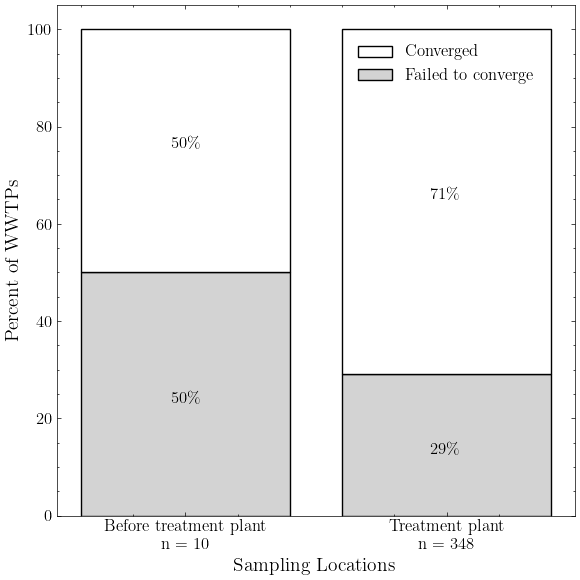

In [7]:
fig,ax = plt.subplots(1,1,figsize=(6,6))
x = ['Before treatment plant\nn = 10','Treatment plant\nn = 348']
y1 = np.array([5/10,101/348])
y2 = np.array([5/10,247/348])
ax.bar(x,y1,color='lightgray',edgecolor='black',label='Failed to converge')
ax.bar(x,y2,bottom=y1,color='white',edgecolor='black',label='Converged')
ax.set_ylabel('Percent of WWTPs',fontsize=14)
ax.set_xlabel('Sampling Locations',fontsize=14)
handles, labels = ax.get_legend_handles_labels()
order = [1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],fontsize=12,loc='upper right',bbox_to_anchor=(0.95,0.95))
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(y) for y in vals])
ax.text(0.22,0.22,'50\%',transform=ax.transAxes,fontsize=12)
ax.text(0.22,0.72,'50\%',transform=ax.transAxes,fontsize=12)
ax.text(0.72,0.12,'29\%',transform=ax.transAxes,fontsize=12)
ax.text(0.72,0.62,'71\%',transform=ax.transAxes,fontsize=12)

ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.savefig('fig6.png',dpi=300)
plt.show()

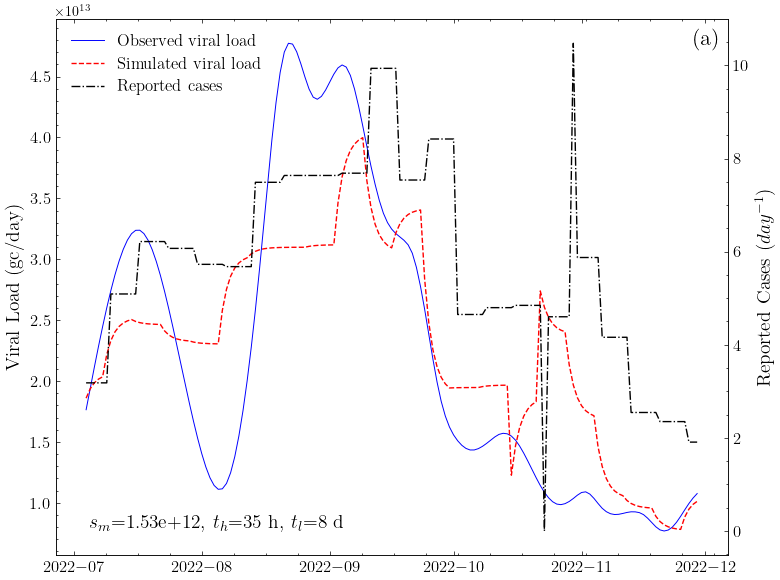

In [8]:
wwtp_id = 1529
sample_df = compiled_data[(compiled_data['wwtp_id'] == wwtp_id)].sort_values(by=['ww_date'])
sm,rd,lt,half_life = res_df[res_df.index == wwtp_id][['sm','rd','lt','half_life']].iloc[0]
lt = int(lt)
cases = sample_df['cases'].values
cases = np.expand_dims(cases,axis=1)
start_date,end_date = sample_df['ww_date'].iloc[0],sample_df['ww_date'].iloc[-1]
days = (end_date-start_date).days
t_li = []
start = sample_df['ww_date'].min()
for ind,val in sample_df['ww_date'].items():
    t_li.append((val-start).days)
t_arr = np.array(t_li,dtype=int)
t_arr = np.expand_dims(t_arr,axis=1)
actual_load = (sample_df['pcr_conc_gc/cap/d']*sample_df['population_served']).to_numpy()

output = cases@(sm*(1-rd)**t_arr.T)
pred = np.zeros_like(actual_load)
for i in range(len(output)):
    pred[i] = np.diagonal(np.fliplr(output),(len(output)-1-i)).sum()

fig,ax = plt.subplots(1,1,figsize=(8,6))
ax2 = ax.twinx()
if lt != 0:
    ax.plot(sample_df['ww_date'].to_numpy()[:-lt],actual_load[:-lt],'b-',lw=0.7,label='Observed viral load')
    ax.plot(sample_df['ww_date'].to_numpy()[:-lt],pred[lt:],'r--',label='Simulated viral load')
    ax2.plot(sample_df['ww_date'].to_numpy()[:-lt],cases[:-lt],'k-.',label='Reported cases')
else:
    ax.plot(sample_df['ww_date'].to_numpy(),actual_load,'b-',lw=0.7,label='Observed viral load')
    ax.plot(sample_df['ww_date'].to_numpy(),pred,'r--',label='Simulated viral load')
    ax2.plot(sample_df['ww_date'].to_numpy(),cases,'k-.',label='Reported cases')
ax.set_ylabel('Viral Load (gc/day)',fontsize=14)
ax2.set_ylabel('Reported Cases ($day^{-1}$)',fontsize=14)

# handle legend
lines_1, labels_1 = ax.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2
ax.legend(lines, labels,loc='upper left',fontsize=12)
ax.text(0.95,0.95,'(a)',transform=ax.transAxes,fontsize=16,weight='bold')
ax.text(0.05,0.05,'$s_m$={:.2e}, $t_h$={:.0f} h, $t_l$={:.0f} d'.format(sm, half_life*24, lt),transform=ax.transAxes,fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.savefig('fig7a.png',dpi=300)
plt.show()

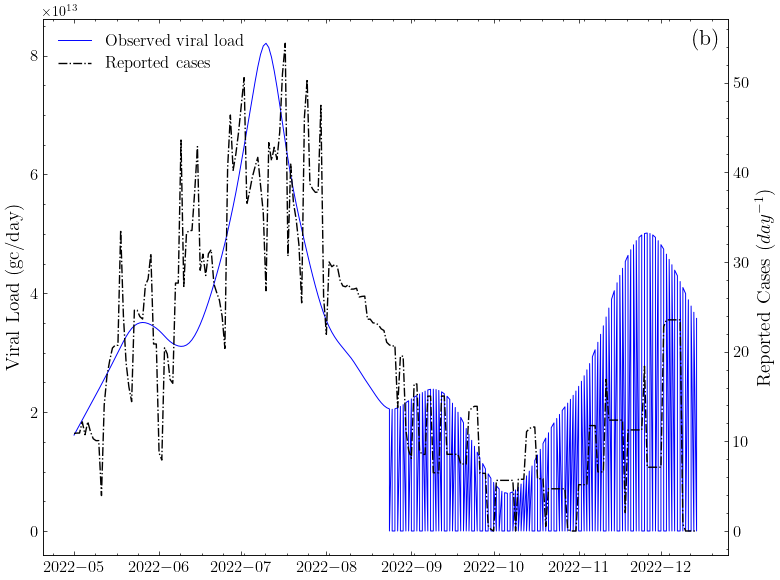

In [9]:
# a sample of failed convergence
wwtp_id = 834
sample_df = compiled_data[(compiled_data['wwtp_id'] == wwtp_id)].sort_values(by=['ww_date'])

cases = sample_df['cases'].values
cases = np.expand_dims(cases,axis=1)
start_date,end_date = sample_df['ww_date'].iloc[0],sample_df['ww_date'].iloc[-1]
days = (end_date-start_date).days
t_li = []
start = sample_df['ww_date'].min()
for ind,val in sample_df['ww_date'].items():
    t_li.append((val-start).days)
t_arr = np.array(t_li,dtype=int)
t_arr = np.expand_dims(t_arr,axis=1)
actual_load = (sample_df['pcr_conc_gc/cap/d']*sample_df['population_served']).to_numpy()

fig,ax = plt.subplots(1,1,figsize=(8,6))
ax2 = ax.twinx()
ax.plot(sample_df['ww_date'].to_numpy(),actual_load,'b-',lw=0.7,label='Observed viral load')
ax2.plot(sample_df['ww_date'].to_numpy(),cases,'k-.',label='Reported cases')
ax.set_ylabel('Viral Load (gc/day)',fontsize=14)
ax2.set_ylabel('Reported Cases ($day^{-1}$)',fontsize=14)

# handle legend
lines_1, labels_1 = ax.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2
ax.legend(lines, labels,loc='upper left',fontsize=12)
ax.text(0.95,0.95,'(b)',transform=ax.transAxes,fontsize=16,weight='bold')

ax.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.savefig('fig7b.png',dpi=300)
plt.show()


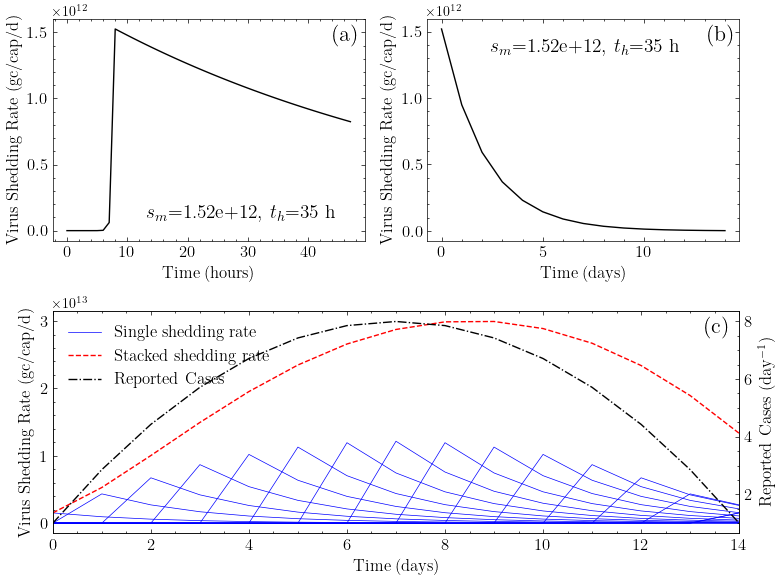

In [10]:
sm,rd,lt = (1.52e12, 0.376, 8)
half_life = 0.693/(-np.log(1-rd))
t_arr_h = np.arange(0,48)
A0,rg = 10,24
s_arr_h = np.ones_like(t_arr_h)*A0
for i in range(len(t_arr_h)-1):
    if i<=7:
        s_arr_h[i+1] = s_arr_h[i]*(1+rg)
    else:
        s_arr_h[i+1] = s_arr_h[i]*(1-rd/24)

t_arr_d = np.arange(0,15)
s_arr_d = np.ones_like(t_arr_d)
for t in t_arr_d:
    s_arr_d[t] = sm*((1-rd)**t)

cases_arr = 8-1/7*(t_arr_d-7)**2
t_arr = np.arange(0,15)
s_arr = np.ones((15,15))
for i in range(15):
    for j in range(15):
        s_arr[i,j] = cases_arr[i]*sm*((1-rd)**j)
s_stacked = np.zeros_like(t_arr)
for i in range(len(s_arr)):
    s_stacked[i] = np.diagonal(np.fliplr(s_arr),(len(s_arr)-1-i)).sum()

fig = plt.figure(figsize=(8,6))
gs = gridspec.GridSpec(2, 2)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[1, :])

ax1.plot(t_arr_h,s_arr_h,'k-')
ax1.set_xlabel('Time (hours)',fontsize=12)
ax1.set_ylabel('Virus Shedding Rate (gc/cap/d)',fontsize=12)
ax1.text(0.9,0.9,'(a)',transform=ax1.transAxes,fontsize=16,weight='bold')
ax1.text(0.3,0.1,'$s_m$={:.2e}, $t_h$={:.0f} h'.format(sm, half_life*24),transform=ax1.transAxes,fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=12)

ax2.plot(t_arr_d,s_arr_d,'k-')
ax2.set_xlabel('Time (days)',fontsize=12)
ax2.set_ylabel('Virus Shedding Rate (gc/cap/d)',fontsize=12)
ax2.text(0.9,0.9,'(b)',transform=ax2.transAxes,fontsize=16,weight='bold')
ax2.text(0.2,0.85,'$s_m$={:.2e}, $t_h$={:.0f} h'.format(sm, half_life*24),transform=ax2.transAxes,fontsize=14)
ax2.tick_params(axis='both', which='major', labelsize=12)

ax4 = ax3.twinx()
for i in range(15):
    s_single = np.zeros_like(t_arr)
    for j in range(i,len(s_single)):
        s_single[j] = s_arr[i,j-i]
    ax3.plot(t_arr,s_single,'b-',lw=0.5)
ax3.plot(t_arr,s_single,'b-',lw=0.5,label='Single shedding rate')
ax3.plot(t_arr,s_stacked,'r--',label='Stacked shedding rate')
ax4.plot(t_arr,cases_arr,'k-.',label='Reported Cases')
ax3.set_xlim([0,14])
ax4.set_xlim([0,14])
ax3.set_xlabel('Time (days)',fontsize=12)
ax3.set_ylabel('Virus Shedding Rate (gc/cap/d)',fontsize=12)
ax4.set_ylabel('Reported Cases (day$^{-1}$)',fontsize=12)
ax3.text(0.95,0.9,'(c)',transform=ax3.transAxes,fontsize=16,weight='bold')
ax3.tick_params(axis='both', which='major', labelsize=12)
ax4.tick_params(axis='both', which='major', labelsize=12)
# handle legend
lines_1, labels_1 = ax3.get_legend_handles_labels()
lines_2, labels_2 = ax4.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2
ax3.legend(lines, labels,loc='upper left',fontsize=12)

plt.tight_layout()
plt.savefig('fig3.png',dpi=300)
plt.show()